In [0]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [0]:
#Reference: https://github.com/subhayanmukherjee/cnninsar
def is_outlier(points, thresh=3.5):
    """    
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = 0
    diff = np.abs(points - median)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * (points - median)/ med_abs_deviation
    return modified_z_score > thresh

def saturate_outlier(img):
    A = np.sqrt( np.absolute(img) )
    angle = np.angle(img) 
    s = A.shape
    x = is_outlier( A.reshape(-1,1) )
    mask = 1- x.reshape(s)
    A1 = mask*A 
    A1 /= np.max(A1)    
    A1[np.logical_and(mask==0,A>np.median(A) )] = 1
    return A1*np.exp(1j*angle)
    
def process_ifg(input_ifg):
    Z_processed = saturate_outlier(input_ifg)
    Z_real = Z_processed.real + 1
    Z_real = np.expand_dims(Z_real, axis=-1)
    Z_imag = Z_processed.imag + 1
    Z_imag = np.expand_dims(Z_imag, axis=-1)
    return np.concatenate((Z_real, Z_imag), axis=-1)

In [0]:
path = '/content/drive/My Drive/slcs/'

In [0]:
imgs = np.zeros(shape=(37, 4951, 1205), dtype=np.complex64)#initializing numpy array to save SLCs
count = 0
for img in tqdm(os.listdir(path)):
    data=np.fromfile(path + img,'<f4').reshape(4951,2*1205)    
    cpx = data[:,0::2] + 1j*data[:,1::2]
    if img=='19971220.slc':
      master = np.copy(cpx)
    else:
      imgs[count] = cpx
      count += 1

100%|██████████| 38/38 [05:06<00:00,  8.52s/it]


In [0]:
intfs=np.zeros(shape=(37, 4951, 1205), dtype=np.complex64)#initializing numpy array to save interferograms
count=0
for img in tqdm(imgs):
  cpx = img
  intfs[count] = master * np.conj(cpx)
  count+=1

100%|██████████| 37/37 [00:01<00:00, 35.75it/s]


In [0]:
processed_intfs = np.zeros(shape=(37, 4951, 1205, 2), dtype=np.float32)#initializing numpy array to save processed interferograms
count=0
for intf in tqdm(intfs):
  processed_intfs[count] = process_ifg(intf)
  count+=1

100%|██████████| 37/37 [00:30<00:00,  1.22it/s]


In [0]:
del imgs, intfs

In [0]:
processed_intfs = np.rollaxis(processed_intfs, 3, 1); processed_intfs.shape#converting from channel last to channel first

(37, 2, 4951, 1205)

In [0]:
PAT_SIZE = 60
INTFS_COUNT = processed_intfs.shape[0]
CHANNELS = processed_intfs.shape[1]
ROWS = processed_intfs.shape[2] 
COLUMNS = processed_intfs.shape[3]
FEATURE_SETS = (ROWS//PAT_SIZE)*(COLUMNS//PAT_SIZE)

In [0]:
X = np.empty((FEATURE_SETS, INTFS_COUNT, CHANNELS, PAT_SIZE, PAT_SIZE))#initializing numpy array to save processed interferograms patches
feature_count = 0

for row_count in tqdm(range(ROWS//PAT_SIZE)):

    for column_count in range (COLUMNS//PAT_SIZE):
        feature_set = []
        for i in range(INTFS_COUNT):
            image_array = processed_intfs[i, :, row_count*PAT_SIZE:(row_count+1)*PAT_SIZE,column_count*PAT_SIZE:(column_count+1)*PAT_SIZE]
            image_array = np.array(image_array).tolist()
            feature_set.append(image_array)
        X[feature_count] = feature_set
        feature_count+=1    

100%|██████████| 82/82 [00:38<00:00,  2.17it/s]


In [0]:
X = X.reshape(-1, CHANNELS, PAT_SIZE, PAT_SIZE)
X = X.astype(np.float32)

In [0]:
np.save('/content/drive/My Drive/X.npy', X)

In [0]:
del processed_intfs
X = torch.tensor(X); X.dtype

torch.float32

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 16, 3, 1, 1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 8, 3, 1, 1),
            nn.ReLU()
        )
        self.maxpooling = nn.Sequential(
            nn.MaxPool2d(3, 3, 1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.ReLU()
        )
        self.upsamp = nn.Upsample(scale_factor=(3, 3))
        self.conv4 = nn.Sequential(
            nn.Conv2d(8, 2, 3, 1, 1),
            nn.ReLU()
        )
    
    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.maxpooling(X)
        X = self.conv3(X)
        X = self.upsamp(X)
        X = self.conv4(X)
        
        return X

In [0]:
net = Net().cuda()
optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()

In [0]:
def fwd_pass(batch_X):
    net.train()
    net.zero_grad()
    outputs = net(batch_X)
    loss = criterion(outputs,batch_X)
    loss.backward()
    optimizer.step() 
    return loss

In [0]:
def one_epoch():
  LOSS = []
  BATCH_SIZE=64
  for i in range(0, len(X), BATCH_SIZE):
    batch_X = X[i:i+BATCH_SIZE].view(-1, 2, PAT_SIZE, PAT_SIZE).cuda()
    loss = fwd_pass(batch_X)
    LOSS.append(loss)
  LOSS = torch.mean(torch.stack(LOSS)) 
  return LOSS

In [0]:
def train():
  EPOCHS=50
  LOSS=[]
  for i in range(EPOCHS):
    loss = one_epoch()
    print(loss)
    LOSS.append(loss)
  return LOSS

In [0]:
LOSS = train()

tensor(0.0472, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0334, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0306, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0280, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0273, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0272, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0267, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0263, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0261, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0260, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0259, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0258, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0257, device='cuda:0',

In [0]:
torch.save({
    'losses': LOSS,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }, "/content/drive/My Drive/ae.pt" )

In [0]:
!python /content/buildset_noisy_sim.py

Finished saving simulated interferogram #1


In [0]:
clean = np.load('/content/drive/My Drive/simtdset/clean_0.npy')
noisy = np.load('/content/drive/My Drive/simtdset/noisy_0.npy')

In [0]:
print(clean.dtype)
print(clean.shape)

complex128
(900, 900)


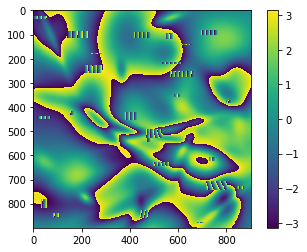

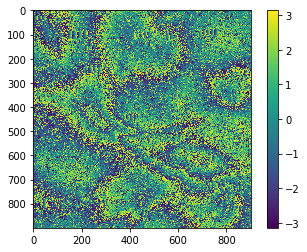

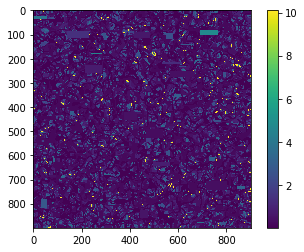

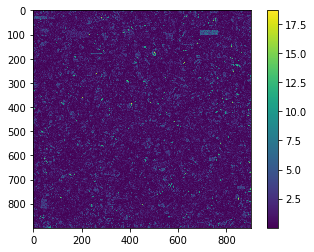

In [0]:
plt.figure(); plt.imshow(np.angle(clean),interpolation="None"); plt.colorbar()
plt.figure(); plt.imshow(np.angle(noisy),interpolation="None"); plt.colorbar()
plt.figure(); plt.imshow(np.abs(clean),interpolation="None"); plt.colorbar()
plt.figure(); plt.imshow(np.abs(noisy),interpolation="None"); plt.colorbar()

In [0]:
processed_noisy = process_ifg(noisy); print(processed_noisy.shape)
processed_noisy = process_ifg(noisy).reshape(1, 900, 900, 2)
processed_noisy = np.rollaxis(processed_noisy, 3, 1); print(processed_noisy.shape)
processed_noisy = processed_noisy.astype(np.float32)
processed_noisy = torch.tensor(processed_noisy).cuda()

(900, 900, 2)
(1, 2, 900, 900)


In [0]:
output = net(processed_noisy); output.shape

torch.Size([1, 2, 900, 900])

In [0]:
output_npy=output.cpu().detach().numpy(); output_npy.dtype

dtype('float32')

In [0]:
output_npy = output_npy.reshape(2, 900, 900);output_npy.shape

(2, 900, 900)

In [0]:
output_npy = np.rollaxis(output_npy, 2, 0)
cpx = output_npy[:,0::2] + 1j*output_npy[:,1::2]
cpx = cpx.reshape(900, 900)

In [0]:
plt.figure(); plt.imshow(np.angle(cpx),interpolation="None"); plt.colorbar()
plt.figure(); plt.imshow(np.abs(cpx),interpolation="None"); plt.colorbar()